# Exercice 3 - Support Vector Classifier

# Support Vector Machines

In [1]:
import numpy as np
import pickle as pkl
from scipy import optimize
from scipy.linalg import cho_factor, cho_solve
import matplotlib.pyplot as plt
from utils import plotClassification, plotRegression, plot_multiple_images, generateRings, scatter_label_points, loadMNIST
%matplotlib inline

## Loading the data

The file 'classification_datasets' contains 3 small classification datasets:
    
    - dataset_1: mixture of two well separated gaussians
    - dataset_2: mixture of two gaussians that are not separeted
    - dataset_3: XOR dataset that is non-linearly separable.
   
Each dataset is a hierarchical dictionary with the following structure:
        
        dataset = {'train': {'x': data, 'y':label}
                    'test': {'x': data, 'y':label}
                  }
The data $x$ is an $N$ by $2$ matrix, while the label $y$ is a vector of size $N$. 

Only the third dateset is used. 

TypeError: plotClassification() got an unexpected keyword argument 'ax'

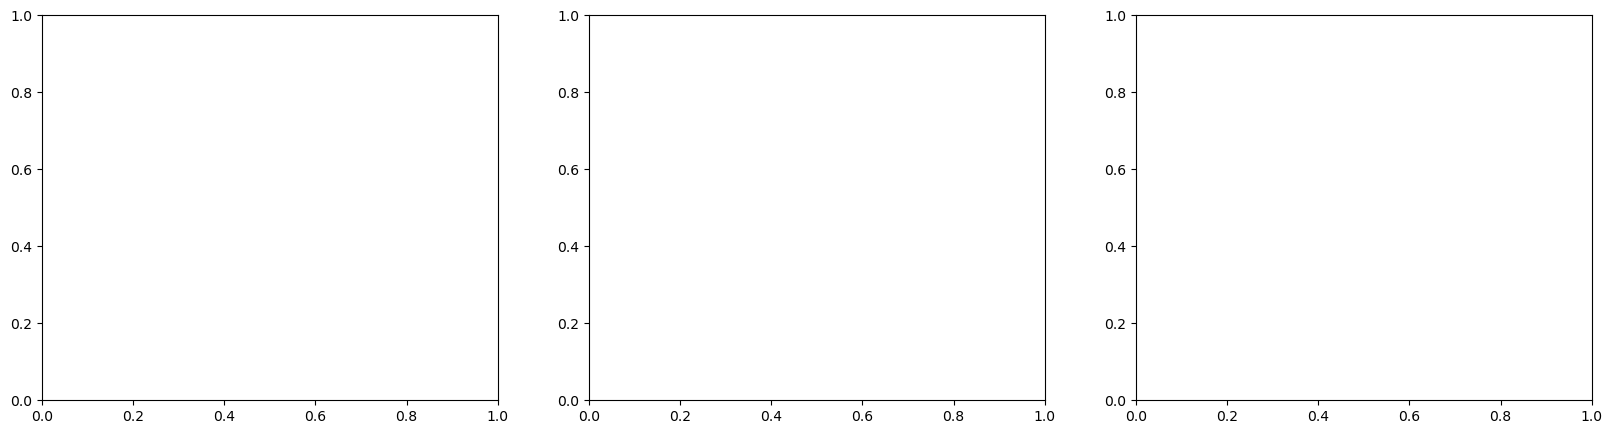

In [2]:
file = open('datasets/classification_datasets', 'rb')
datasets = pkl.load(file)
file.close()
fig, ax = plt.subplots(1,3, figsize=(20, 5))

for i, (name, dataset) in enumerate(datasets.items()):    
    plotClassification(dataset['train']['x'], dataset['train']['y'], ax=ax[i])
    ax[i].set_title(name)

## III- Kernel SVC 
### 1- Implementing the Gaussian Kernel
Implement the method 'kernel' of the class RBF and linear below, which takes as input two data matrices $X$ and $Y$ of size $N\times d$ and $M\times d$ and returns a gramm matrix $G$ of shape $N\times M$ whose components are $k(x_i,y_j) = \exp(-\Vert x_i-y_j\Vert^2/(2\sigma^2))$ for the RBF kernel and $k(x_i,y_j)= x_i^{\top}y_j$ for the linear kernel. (The fastest solution does not use any for loop!)

In [2]:
class RBF:
    def __init__(self, sigma=1.):
        self.sigma = sigma  ## the variance of the kernel
    def kernel(self,X,Y):
        ## Input vectors X and Y of shape Nxd and Mxd
        squared_distances = np.array([ [ np.sum((x[i,:]-y[j,:])**2) for j in range(y.shape[0]) ] for i in range(x.shape[0])])
        return np.exp( -1/(2*sigma**2) * squared_distances )

In [3]:
class Linear:
    def kernel(self,X,Y):
        ## Input vectors X and Y of shape Nxd and Mxd
        return  X @ Y.T

## Question 1

Representer theorem :

$f(x) = \sum_{i=1}^n \alpha_i \textbf{K}(x_i,x)$

Lagrangien :

$\mathcal{L}(\alpha,\xi,b, \mu,\nu) = \frac{1}{2}\alpha^T \textbf{K} \alpha + C \sum_{i=1}^{n}\xi_i - \sum_{i=1}^{n} \mu_i \left( y_i ( [\textbf{K}\alpha]_i + b) + \xi_i - 1 \right) - \sum_{i=1}^{n} \nu_i \xi_i$

Gradients :

$\nabla_\alpha \mathcal{L} = \textbf{K} \left( \alpha - \text{diag}(y)\mu \right)$

$\nabla_\xi \mathcal{L} = C \textbf{1} - (\nu + \mu)$

$\nabla_b \mathcal{L} = \mu^T y$

Optimal points :

$\alpha^* = \text{diag}(y) \mu$

$\mu + \nu = C\textbf{1}$

$\mu^T y = 0$

Dual function :

$g(\nu,\mu) = \underset{\alpha, \xi, b}{\text{inf}}\,\,\mathcal{L} = -\frac{1}{2} \text{diag}(y) \mu^T \textbf{K} \mu \text{diag}(y) + \mu^T \textbf{1}$

st $\mu + \nu = C$ et $\mu^T y = 0$

Complementary slackness :

$\alpha_i \left( y_i (f(x_i) + b) + \xi_i - 1 \right) = 0, \,\, \forall i$

$\left( C y_i - \alpha_i\right) \xi_i = 0, \,\, \forall i$

Dual problem :

$ \underset{\alpha}{\text{min}} \,\, \frac{1}{2}\alpha^T \textbf{K} \alpha - \alpha^T y $

st : $0 \leq \alpha_i y_i \leq C, \,\, \forall i$ et $ \alpha^T y = 0$

(NB : on utilise le fait que $\alpha_i = y_i \mu_i \implies \mu_i = \alpha_i y_i \,\, \forall i$ puisque $y_i = \pm 1$...)

Support vector points :

$\alpha_i = 0 \implies \xi=0, \,\, y_i (f(x_i)+b) > 1$  point bien classé

$\alpha_i y_i = C \implies \xi_i >0, \,\,  y_i (f(x_i)+b) < 1$ point avec marge inférieure à 1

$0 < \alpha_i y_i < C \implies y_i (f(x_i)+b) = 1$ support vector

Parameter b :

Sur l'ensemble $\mathcal{S}$ des support vectors, on résoud $y_i (f(x_i)+b) = 1$ puis on moyenne, d'où $b = \frac{1}{\vert \mathcal{S} \vert} \sum_{\mathcal{S}} \left( \frac{1}{y_i} - \textbf{K}\alpha \vert_i \right) $


### 2- Implementing the classifier
Implement the methods 'fit' and 'separating_function' of the class KernelSVC below to learn the Kernel Support Vector Classifier.

In [ ]:
class KernelSVC:
    
    def __init__(self, C, kernel, epsilon = 1e-3):
        self.type = 'non-linear'
        self.C = C                               
        self.kernel = kernel        
        self.alpha = None
        self.support = None # support vectors
        self.epsilon = epsilon
        self.norm_f = None
       
    
    def fit(self, X, y):
        #### You might define here any variable needed for the rest of the code
        N = len(y)
        self.X = X
        self.y = y
        # compute gram matrix, we might need it :-)
        self.gram = self.kernel(X,X)
        # vector of ones, size N
        ones = np.ones(N)
        # matrix NxN of y_i on diagonal
        Dy = np.diag(y)

        # Lagrange dual problem
        def loss(alpha):
            objective_function = 1/2 * alpha @ self.gram @ alpha - alpha @ y
            return  objective_function

        # Partial derivate of Ld on alpha
        def grad_loss(alpha):
            gradient = self.gram @ alpha - y
            return gradient
        
        # Constraints on alpha of the shape :
        # -  d - C*alpha  = 0
        # -  b - A*alpha >= 0

        fun_eq = lambda alpha: alpha @ y        
        jac_eq = lambda alpha: y
        fun_ineq_1 = lambda alpha: Dy @ alpha    
        jac_ineq_1 = lambda alpha: Dy  # '''---------------jacobian wrt alpha of the  inequality constraint-------------------'''
        fun_ineq_2 = lambda alpha : C * ones - Dy @ alpha
        jac_ineq_2 = lambda alpha: -Dy  # '''---------------jacobian wrt alpha of the  inequality constraint-------------------'''
        # fun_ineq = lambda alpha: np.concatenate((fun_ineq_1(alpha), fun_ineq_2(alpha)))
        
        constraints = ( [{'type': 'eq', 'fun': fun_eq, 'jac': jac_eq},
                        {'type': 'ineq', 'fun': fun_ineq_1, 'jac': jac_ineq_1},
                        {'type': 'ineq', 'fun': fun_ineq_2, 'jac': jac_ineq_2}]
                        )

        optRes = optimize.minimize(fun=lambda alpha: loss(alpha),
                                   x0=np.ones(N), 
                                   method='SLSQP', 
                                   jac=lambda alpha: grad_loss(alpha), 
                                   constraints=constraints)
        self.alpha = optRes.x

        ## Assign the required attributes
    
        #'''------------------- A matrix with each row corresponding to support vectors ------------------'''
        # list of indices of support vectors in dataset, None if not a support vector
        self.indices_support = np.array([ i if (0 < self.alpha[i]*y[i]) and (self.alpha[i]*y[i] < C) else None for i in range(N) ])
        # support vectors
        self.support = np.array([ self.alpha[i] if self.indices_support[i] is not None else None for i in range(N) ]) 
        self.support = self.support[self.support != None]
        # data points of support vectors
        self.X_sv = np.zeros((self.support.shape[0],self.X.shape[1]))
        isv = 0
        for i in range(N):
            if self.indices_support[i] is not None:
                self.X_sv[isv,:] = X[i]
                isv += 1
        #'''------------------- b offset of the classifier ------------------'''
        b = 0
        Ka = self.gram @ self.alpha
        for i in range(N):
            if self.indices_support[i] is not None:
                b += 1/y[i] - Ka[i]
        self.b = b / len(self.support)
        # '''------------------------RKHS norm of the function f ------------------------------'''
        self.norm_f = 1/2 * self.alpha @ self.gram @ self.alpha
        
        return self


    ### Implementation of the separting function $f$ 
    def separating_function(self,x):
        # Input : matrix x of shape N data points times d dimension
        # Output: vector of size N
        return self.kernel(x, self.X_sv) @ self.support + self.b
    
    
    def predict(self, X):
        """ Predict y values in {-1, 1} """
        d = self.separating_function(X)
        return 2 * (d+self.b> 0) - 1

# 2 b- Implementing the visualization function
Implement the function plotClassification that takes new data as input and the model, then displays separating function and margins along with misclassified points.

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.colors as pltcolors
import seaborn as sns

def plotHyperSurface(ax, xRange, model, intercept, label, color='grey', linestyle='-', alpha=1.):
    #xx = np.linspace(-1, 1, 100)
    if model.type=='linear':
        xRange = np.array(xRange)
        yy = -(model.w[0] / model.w[1]) * xRange  - intercept/model.w[1]
        ax.plot(xRange, yy, color=color, label=label, linestyle=linestyle)
    else:
        xRange = np.linspace(xRange[0], xRange[1], 100)
        X0, X1 = np.meshgrid(xRange, xRange)
        xy = np.vstack([X0.ravel(), X1.ravel()]).T
        Y30 = model.separating_function(xy).reshape(X0.shape) + intercept
        ax.contour(X0, X1, Y30, colors=color, levels=[0.], alpha=alpha, linestyles=[linestyle]);


def plotClassification(X, y, model=None, label='',  separatorLabel='Separator', 
            ax=None, bound=[[-1., 1.], [-1., 1.]]):
    """ Plot the SVM separation, and margin """
    colors = ['blue','red']
    labels = [1,-1]
    cmap = pltcolors.ListedColormap(colors)
    if ax is None:
        fig, ax = plt.subplots(1, figsize=(11, 7))
    for k, label in enumerate(labels):
        im = ax.scatter(X[y==label,0], X[y==label,1],  alpha=0.5,label='class '+str(label))

    if model is not None:
        # Plot the seprating function
        plotHyperSurface(ax, bound[0], model, model.b, separatorLabel)
        if model.support is not None:
            ax.scatter(model.support[:,0], model.support[:,1], label='Support', s=80, facecolors='none', edgecolors='r', color='r')
            print("Number of support vectors = %d" % (len(model.support)))
        
        # Plot the margins
        intercept_neg = ### compute the intercept for the negative margin
        intercept_pos = ### compute the intercept for the positive margin
        xx = np.array(bound[0])
        plotHyperSurface(ax, xx, model, intercept_neg , 'Margin -', linestyle='-.', alpha=0.8)
        plotHyperSurface(ax, xx, model, intercept_pos , 'Margin +', linestyle='--', alpha=0.8)
            
        # Plot points on the wrong side of the margin
        wrong_side_points = # find wrong points
        ax.scatter(wrong_side_points[:,0], wrong_side_points[:,1], label='Beyond the margin', s=80, facecolors='none', 
               edgecolors='grey', color='grey')  
        
    ax.legend(loc='upper left')
    ax.grid()
    ax.set_xlim(bound[0])
    ax.set_ylim(bound[1])

### 3- Fitting the classifier

Run the code block below to fit the classifier and report its output.

### Dataset 1
#### Linear classifier

In [ ]:
C=1.
kernel = Linear().kernel
model = KernelSVC(C=C, kernel=kernel, epsilon=1e-14)
train_dataset = datasets['dataset_1']['train']
model.fit(train_dataset['x'], train_dataset['y'])
plotClassification(train_dataset['x'], train_dataset['y'], model, label='Training')

#### Gaussian classifier

In [ ]:
sigma = 1.5
C=1.
kernel = RBF(sigma).kernel
model = KernelSVC(C=C, kernel=kernel, epsilon=1e-14)
train_dataset = datasets['dataset_1']['train']
model.fit(train_dataset['x'], train_dataset['y'])
plotClassification(train_dataset['x'], train_dataset['y'], model, label='Training')

### Dataset 2
#### Linear SVM

In [ ]:
C=.1
kernel = Linear().kernel
model = KernelSVC(C=C, kernel=kernel, epsilon=1e-14)
train_dataset = datasets['dataset_2']['train']
model.fit(train_dataset['x'], train_dataset['y'])
plotClassification(train_dataset['x'], train_dataset['y'], model, label='Training')

#### Gaussian SVM

In [ ]:
sigma = 1.5
C=1.
kernel = RBF(sigma).kernel
model = KernelSVC(C=C, kernel=kernel, epsilon=1e-14)
train_dataset = datasets['dataset_2']['train']
model.fit(train_dataset['x'], train_dataset['y'])
plotClassification(train_dataset['x'], train_dataset['y'], model, label='Training')

### Dataset 3
#### Linear SVM

In [ ]:
C=1.
kernel = Linear().kernel
model = KernelSVC(C=C, kernel=kernel, epsilon=1e-14)
train_dataset = datasets['dataset_3']['train']
model.fit(train_dataset['x'], train_dataset['y'])
plotClassification(train_dataset['x'], train_dataset['y'], model, label='Training')

#### Gaussian SVM

In [ ]:
sigma = 1.5
C=100.
kernel = RBF(sigma).kernel
model = KernelSVC(C=C, kernel=kernel)
train_dataset = datasets['dataset_3']['train']
model.fit(train_dataset['x'], train_dataset['y'])
plotClassification(train_dataset['x'], train_dataset['y'], model, label='Training')